In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import pandas as pd

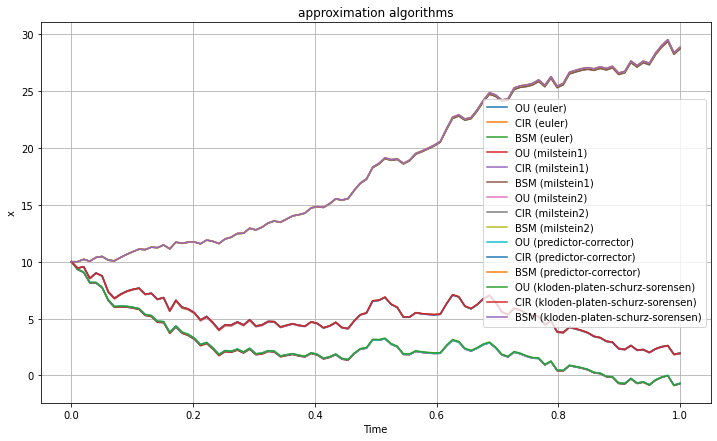

In [8]:
#task 1 - approximation algorithms of SDE

def euler_approximation(y_i, b, delta, sigma, delta_w):
  y = y_i + b * delta + sigma * delta_w
  return y

def milstein_scheme1_approximation(y_i, b, delta, sigma, sigma_x, delta_w):
  y = (y_i + b * delta + sigma * delta_w 
       + 1/2 * sigma * sigma_x * (delta_w**2 - delta)
      )
  return y

def milstein_scheme2_approximation(delta_w, b, b_x, sigma, sigma_x, b_xx, sigma_xx, y_i, delta, z):
  y = (y_i
       + (b - 1/2 * sigma * sigma_x) * delta
       + sigma * z * np.sqrt(delta)
       + 1/2 * sigma * sigma_x * delta * z**2
       + delta**(3/2) * (1/2 * b * sigma_x + 1/2 * b_x * sigma + 1/4 * sigma**2 * sigma_xx) * z
       + delta**2 * (1/2 * b * b_x + 1/4 * b_xx * sigma**2)
       )
  return y

def y_wave(y, b, delta, sigma, z):
  return y + b * delta + sigma * np.sqrt(delta) * z

def b_wave(b, nu, sigma, sigma_x):
  return b - nu * sigma * sigma_x

def predictor_corrector_method(y, delta, b, b_y_wave, sigma, sigma_x, sigma_y_wave, sigma_y_wave_x, z, nu, alpha):
  b_wave_y = b_wave(b, nu, sigma, sigma_x)
  b_wave_y_wave = b_wave(b_y_wave, nu, sigma_y_wave, sigma_y_wave_x)
  
  y_i = (y + (alpha * b_wave_y_wave + (1 - alpha) * b_wave_y) * delta
         + (nu * sigma_y_wave + (1 - nu) * sigma) * np.sqrt(delta) * z
        )
  return y_i

def kloden_platen_schurz_sorensen_method(y, b, b_x, b_xx, sigma, sigma_x, sigma_xx, s, delta, delta_w, z):
  delta_u = z * 1/3 * delta**3
  y_i = (y
         + b * delta 
         + sigma * delta_w
         + 1/2 * sigma * sigma_x * (delta_w**2 - delta)
         + sigma * b_x * delta_u
         + 1/2 * (b * b_x + 1/2 * sigma**2 * b_xx) * delta**2
         + (b * sigma_x + 1/2 * sigma**2 * sigma_xx) * (delta_w * delta - delta_u)
         + 1/2 * sigma * s * (1/3 * delta_w**2 - delta) * delta_w
         )
  return y_i

def Ornstein_Uhlenbeck_process(x0, N, T, theta, t, sigma, delta, delta_w, z, approximation_method):
  x = np.zeros(N)
  x[0] = x0
  delta = T / N

  nu = 0.5
  alpha = 0.5

  for i in range(1, N):
    b = - theta * x[i-1]
    b_x = - theta
    b_xx = 0

    sigma_x = 0
    sigma_xx = 0

    if approximation_method == "euler":
      x[i] = euler_approximation(x[i-1], b, delta, sigma, delta_w[i])
    elif approximation_method == "milstein1":
      x[i] = milstein_scheme1_approximation(x[i-1], b, delta, sigma, sigma_x, delta_w[i])
    elif approximation_method == "milstein2":
      x[i] = milstein_scheme2_approximation(delta_w[i], b, b_x, sigma, sigma_x, b_xx, sigma_xx, x[i-1], delta, z[i])
    elif approximation_method == "predictor-corrector":
      y_wave_value = y_wave(x[i-1], b, delta, sigma, z[i])
      b_y_wave = - theta * y_wave_value
      sigma_y_wave = sigma
      sigma_y_wave_x = sigma_x
      x[i] = predictor_corrector_method(x[i-1], delta, b, b_y_wave, sigma, sigma_x, sigma_y_wave, sigma_y_wave_x, z[i], nu, alpha)
    elif approximation_method == "kloden-platen-schurz-sorensen":
      s = 0
      x[i] = kloden_platen_schurz_sorensen_method(x[i-1], b, b_x, b_xx, sigma, sigma_x, sigma_xx, s, delta, delta_w[i], z[i])
      
  return x

def Cox_Ingersoll_Ross_process(theta1, theta2, theta3, x0, N, T, t, delta, delta_w, z, approximation_method):
  x = np.zeros(N)
  x[0] = x0
  delta = T / N

  nu = 0.5
  alpha = 0.5

  for i in range(1, N):
    b = theta1 - theta2 * x[i-1]
    b_x = - theta2
    b_xx = 0

    sigma = theta3 * (x[i-1])**(1/2)
    sigma_x = 1/2 * theta3 * (x[i-1])**(-1/2)
    sigma_xx = - 1/4  * theta3 * (x[i-1])**(-3/2)

    if approximation_method == "euler":
      x[i] = euler_approximation(x[i-1], b, delta, sigma, delta_w[i])
    elif approximation_method == "milstein1":
      x[i] = milstein_scheme1_approximation(x[i-1], b, delta, sigma, sigma_x, delta_w[i])
    elif approximation_method == "milstein2":
      x[i] = milstein_scheme2_approximation(delta_w[i], b, b_x, sigma, sigma_x, b_xx, sigma_xx, x[i-1], delta, z[i])
    elif approximation_method == "predictor-corrector":
      y_wave_value = y_wave(x[i-1], b, delta, sigma, z[i])
      b_y_wave = theta1 - theta2 * y_wave_value
      sigma_y_wave = theta3 * y_wave_value**(1/2)
      sigma_y_wave_x = 1/2 * theta3 * y_wave_value**(-1/2)
      x[i] = predictor_corrector_method(x[i-1], delta, b, b_y_wave, sigma, sigma_x, sigma_y_wave, sigma_y_wave_x, z[i], nu, alpha)
    elif approximation_method == "kloden-platen-schurz-sorensen":
      s = 0
      x[i] = kloden_platen_schurz_sorensen_method(x[i-1], b, b_x, b_xx, sigma, sigma_x, sigma_xx, s, delta, delta_w[i], z[i])
     
  return x

def Black_Scholes_Merton_process(theta1, theta2, x0, N, T, t, delta, delta_w, z, approximation_method):
  x = np.zeros(N)
  x[0] = x0

  nu = 0.5
  alpha = 0.5
  for i in range(1, N):
    b = theta1 * x[i-1]
    b_x = theta1
    b_xx = 0

    sigma = theta2 * x[i-1]
    sigma_x = theta2
    sigma_xx = 0

    if approximation_method == "euler":
      x[i] = euler_approximation(x[i-1], b, delta, sigma, delta_w[i])
    elif approximation_method == "milstein1":
      x[i] = milstein_scheme1_approximation(x[i-1], b, delta, sigma, sigma_x, delta_w[i])
    elif approximation_method == "milstein2":
      x[i] = milstein_scheme2_approximation(delta_w[i], b, b_x, sigma, sigma_x, b_xx, sigma_xx, x[i-1], delta, z[i])
    elif approximation_method == "predictor-corrector":
      y_wave_value = y_wave(x[i-1], b, delta, sigma, z[i])
      b_y_wave = theta1 * y_wave_value
      sigma_y_wave = theta2 * y_wave(x[i-1], b, delta, sigma, z[i])
      sigma_y_wave_x = sigma_x
      x[i] = predictor_corrector_method(x[i-1], delta, b, b_y_wave, sigma, sigma_x, sigma_y_wave, sigma_y_wave_x, z[i], nu, alpha)
    elif approximation_method == "kloden-platen-schurz-sorensen":
      s = theta2**2
      x[i] = kloden_platen_schurz_sorensen_method(x[i-1], b, b_x, b_xx, sigma, sigma_x, sigma_xx, s, delta, delta_w[i], z[i])
      
  return x

def plot_approximation_algorithms():
  x0 = 10
  N = 100
  T = 1
  t = np.linspace(0, T, N)

  delta = T / N
  delta_w = np.zeros(N)

  z = np.random.normal(0, 1, N)
  delta_w = z * np.sqrt(delta)

  approximation_algorithms = ["euler", "milstein1", "milstein2", "predictor-corrector", "kloden-platen-schurz-sorensen"]

  plt.figure(figsize=(12, 7))

  for algorithm in approximation_algorithms:
    theta = 5
    sigma = 3.5
    x = Ornstein_Uhlenbeck_process(x0, N, T, theta, t, sigma, delta, delta_w, z, algorithm)
    plt.plot(t, x, label = f'OU ({algorithm})')

    theta1 = 6
    theta2 = 3
    theta3 = 2
    x = Cox_Ingersoll_Ross_process(theta1, theta2, theta3, x0, N, T, t, delta, delta_w, z, algorithm)
    plt.plot(t, x, label = f'CIR ({algorithm})')

    theta1 = 1
    theta2 = 0.2
    x = Black_Scholes_Merton_process(theta1, theta2, x0, N, T, t, delta, delta_w, z, algorithm)
    plt.plot(t, x, label = f'BSM ({algorithm})')

  plt.grid()
  plt.title('approximation algorithms')
  plt.xlabel('Time')
  plt.ylabel('x')
  plt.legend()
  plt.show()

plot_approximation_algorithms()

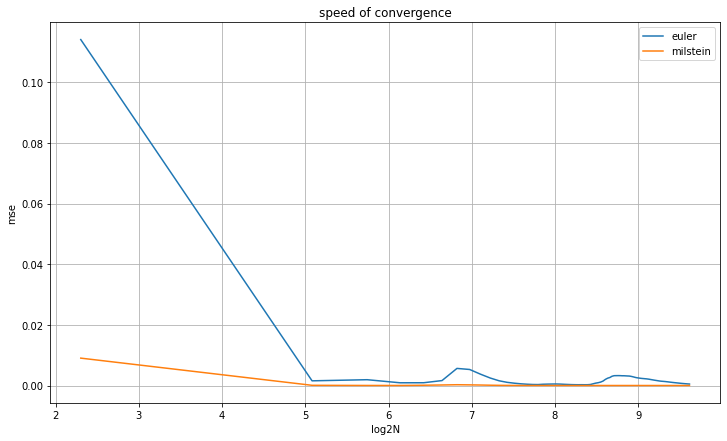

In [9]:
#task 2 - convergence of approximation algorithms to exact equation

def Black_Scholes_Merton_process_exact(x0, N, theta1, theta2, delta_w, delta):
  x = np.zeros(N)
  x[0] = x0
  for i in range(1, N):
    x[i] = x[i-1] * np.exp((theta1 - theta2**2 / 2) * delta + theta2 * delta_w[i])
  return x

def estimate_speed_of_convergence():
  st = 15
  x0 = 10
  T = 0.5
  theta1 = 1
  theta2 = 0.7
  z = np.random.normal(0, 1, 2**st)
  N_values = np.linspace(10, 15000, 100).astype(np.int64)

  mse_euler = []
  mse_milstein = []
  for N in N_values:
    t = np.linspace(0, T, N)
    delta = T / N
    delta_w = z[:N] * np.sqrt(delta)
    x_exact = Black_Scholes_Merton_process_exact(x0, N, theta1, theta2, delta_w, delta)
    x_euler = Black_Scholes_Merton_process(theta1, theta2, x0, N, T, t, delta, delta_w, z[:N], "euler")
    x_milstein = Black_Scholes_Merton_process(theta1, theta2, x0, N, T, t, delta, delta_w, z[:N], "milstein1")
    mse_euler.append(mse(x_exact, x_euler))
    mse_milstein.append(mse(x_exact, x_milstein))

  plt.figure(figsize=(12, 7))
  plt.plot(np.log(N_values), mse_euler, label='euler')
  plt.plot(np.log(N_values), mse_milstein, label='milstein')

  plt.grid()
  plt.title('speed of convergence')
  plt.xlabel('log2N')
  plt.ylabel('mse')
  plt.legend()
  plt.show()

estimate_speed_of_convergence()

In [15]:
#task 3 - random number generators

def ou_random_number_generator(x, theta1, theta2, theta3, t, delta_w, N):
  ou_mean = theta1 / theta2 + (x - theta1 / theta2) * np.exp(- theta2 * t)
  ou_variance = theta3**2 / (2 * theta2) * (1 - np.exp(- 2 * theta2 * t))
  return np.random.normal(ou_mean, ou_variance, 1)
  
def bsm_random_number_generator(x, theta1, theta2, delta, delta_w, N):
  bsm_lmean = np.log(x) + (theta1 - 1/2 * theta2**2) * delta
  bsm_lsd = np.sqrt(delta) * theta2
  return np.random.lognormal(bsm_lmean, bsm_lsd, 1)

def cir_random_number_generator(x, theta1, theta2, theta3, t, delta, delta_w, N):
  c = 2 * theta2 / ((1 - np.exp(- theta2 * t)) * theta3**2) 
  ncp = 2 * c * x * np.exp(- theta2 * delta)
  df = 4 * theta1 / theta3**2 
  return np.random.chisquare(df) / (2 * c)

def generate_random_numbers(to_save_flag):
  x0 = 10
  N = 100
  T = 1

  theta1 = 2
  theta2 = 0.3
  theta3 = 6

  delta = T / N
  z = np.random.normal(0, 1, N)
  delta_w = z * np.sqrt(delta)

  ou_random_numbers = []
  bsm_random_numbers = []
  cir_random_numbers = []
  for t in range(1, 101):
    ou_random_numbers.append(ou_random_number_generator(x0, theta1, theta2, theta3, delta, delta_w, N))
    bsm_random_numbers.append(bsm_random_number_generator(x0, theta1, theta2, delta, delta_w, N))
    cir_random_numbers.append(cir_random_number_generator(x0, theta1, theta2, theta3, t, delta, delta_w, N))

  if to_save_flag:
    d = {'ou_random_numbers': ou_random_numbers, 'bsm_random_numbers': bsm_random_numbers, 'cir_random_numbers': cir_random_numbers}
    df = pd.DataFrame(d) 
    df.to_csv('random_numbers.csv')

  return ou_random_numbers, bsm_random_numbers, cir_random_numbers

ou_random_numbers, bsm_random_numbers, cir_random_numbers = generate_random_numbers(to_save_flag=False)

ou 90%-percentile =  10.450582447352268
bsm 90%-percentile =  10.626776809868417
cir 90%-percentile =  12.310446158008666



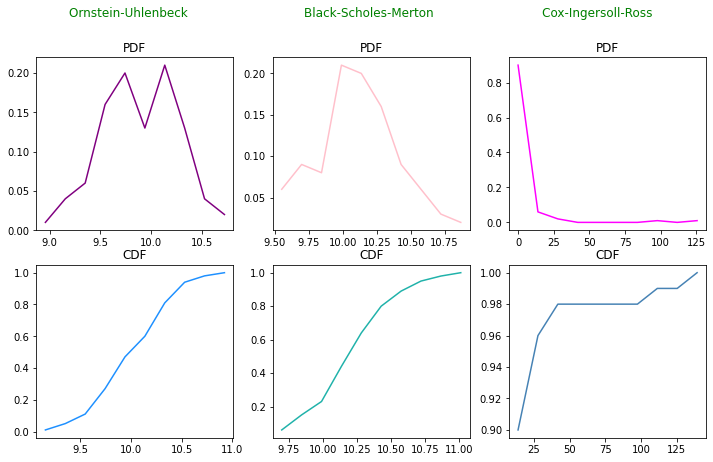

In [17]:
#task 4 - cumulative distribution, density function, calculate the 90%-quantile

def cdf_pdf(random_numbers):
  count, bins_count = np.histogram(random_numbers)
  pdf = count / sum(count)
  cdf = np.cumsum(pdf)
  return pdf, cdf, bins_count

def eval_90_percentile(random_numbers):
  return np.percentile(random_numbers, 90)

def plot_cdf_pdf():
  ou_random_numbers, bsm_random_numbers, cir_random_numbers = generate_random_numbers(to_save_flag=False)
  ou_pdf, ou_cdf, ou_bins_count = cdf_pdf(ou_random_numbers)
  bsm_pdf, bsm_cdf, bsm_bins_count = cdf_pdf(bsm_random_numbers)
  cir_pdf, cir_cdf, cir_bins_count = cdf_pdf(cir_random_numbers)

  fig, axs = plt.subplots(2, 3, figsize=(12, 7))
  axs[0][0].plot(ou_bins_count[:-1], ou_pdf, label="PDF", color="purple")
  axs[0][1].plot(bsm_bins_count[:-1], bsm_pdf, label="PDF", color="pink")
  axs[0][2].plot(cir_bins_count[:-1], cir_pdf, label="PDF", color="magenta")

  axs[1][0].plot(ou_bins_count[1:], ou_cdf, label="CDF", color="dodgerblue")
  axs[1][1].plot(bsm_bins_count[1:], bsm_cdf, label="CDF", color="lightseagreen")
  axs[1][2].plot(cir_bins_count[1:], cir_cdf, label="CDF", color="steelblue")

  t = "PDF"
  for i in range(2):
    for j in range(3):
      axs[i][j].set_title(t)
    t = "CDF"

  fig.suptitle("Ornstein-Uhlenbeck                              Black-Scholes-Merton                            Cox-Ingersoll-Ross", color="green")
  fig.show()
  print("ou 90%-percentile = ", eval_90_percentile(ou_random_numbers))
  print("bsm 90%-percentile = ", eval_90_percentile(bsm_random_numbers))
  print("cir 90%-percentile = ", eval_90_percentile(cir_random_numbers))
  print()

plot_cdf_pdf()

il 90%-percentile =  76.31892442198384
sl 90%-percentile =  21.66492718092703



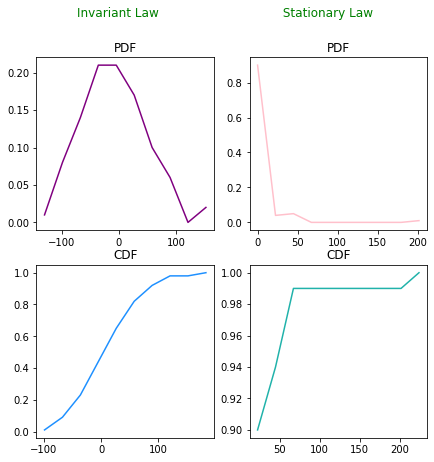

In [21]:
# task 5 - invariant and stationary law

def invariant_law_random_number_generator(theta1, theta2, theta3):
  il_mean = theta1 / theta2
  il_variance = theta3**2 / (2 * theta2)
  return np.random.normal(il_mean, il_variance, 1)

def stationary_law_random_number_generator(theta1, theta2, theta3):
  sl_shape = 2*theta1 / theta3**2
  sl_scale = theta3**2 / (2 * theta2)
  return np.random.gamma(sl_shape, sl_scale, 1)

def generate_random_number_by_laws(to_save_flag):
  theta1 = 2
  theta2 = 0.3
  theta3 = 6

  il_random_numbers = []
  sl_random_numbers = []

  for t in range(1, 101):
    il_random_numbers.append(invariant_law_random_number_generator(theta1, theta2, theta3))
    sl_random_numbers.append(stationary_law_random_number_generator(theta1, theta2, theta3))

  if to_save_flag:
    d = {'il_random_numbers': il_random_numbers, 'sl_random_numbers': sl_random_numbers}
    df = pd.DataFrame(d) 
    df.to_csv('random_numbers_for_stationary_laws.csv')

  return il_random_numbers, sl_random_numbers

def plot_cdf_pdf_by_laws():
  il_random_numbers, sl_random_numbers = generate_random_number_by_laws(to_save_flag=False)
  il_pdf, il_cdf, il_bins_count = cdf_pdf(il_random_numbers)
  sl_pdf, sl_cdf, sl_bins_count = cdf_pdf(sl_random_numbers)

  fig, axs = plt.subplots(2, 2, figsize=(7, 7))
  axs[0][0].plot(il_bins_count[:-1], il_pdf, label="PDF", color="purple")
  axs[0][1].plot(sl_bins_count[:-1], sl_pdf, label="PDF", color="pink")
  axs[1][0].plot(il_bins_count[1:], il_cdf, label="CDF", color="dodgerblue")
  axs[1][1].plot(sl_bins_count[1:], sl_cdf, label="CDF", color="lightseagreen")

  t = "PDF"
  for i in range(2):
    for j in range(2):
      axs[i][j].set_title(t)
    t = "CDF"

  fig.suptitle("Invariant Law                                Stationary Law", color="green")
  fig.show()

  print("il 90%-percentile = ", eval_90_percentile(il_random_numbers))
  print("sl 90%-percentile = ", eval_90_percentile(sl_random_numbers))
  print()

plot_cdf_pdf_by_laws()